# Importando librerías

In [17]:
import os
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from skimage.io import imread #read images from files
# import matplotlib.patches as patches
# from PIL import Image

import cv2

# Revisando los labels de train

In [18]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

# Me quedo solo con 1000 filas para que el procesamiento de esto sea más rápido

In [19]:
df = df.sample(1000)

In [20]:
cancer_positive = df[df["label"] == 1].sample(5)['id']


cancer_negative = df[df["label"] == 0].sample(5)['id']


In [21]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img



Text(0, 0.5, 'Tumor tissue samples')

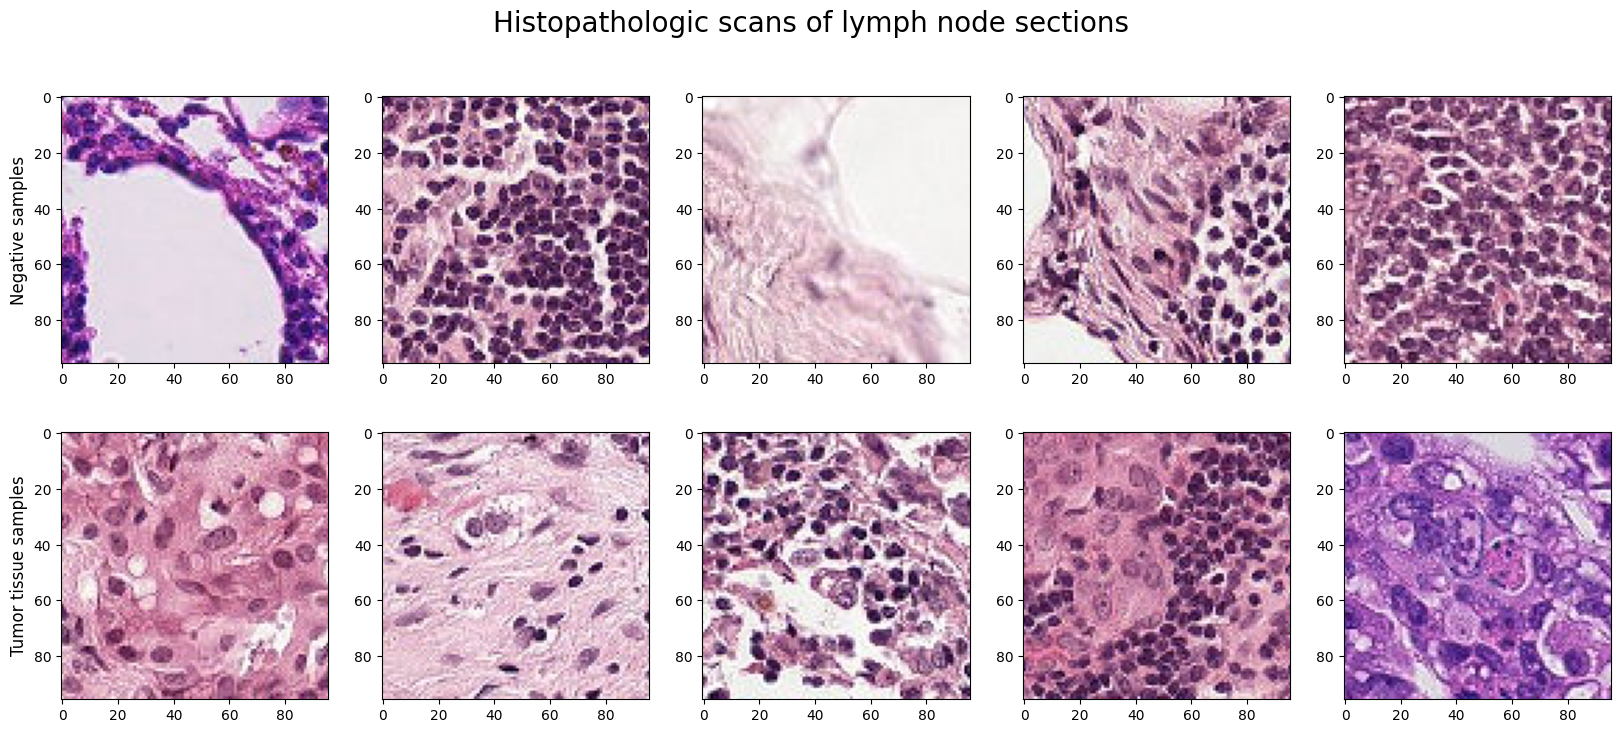

In [22]:

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
path_dir = '../input/histopathologic-cancer-detection'

# Negatives
for i, idx in enumerate(cancer_negative):
    path = os.path.join(path_dir, 'train', idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(cancer_positive):
    path = os.path.join(path_dir, 'train', idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [23]:
# Leyendo imágenes
df['image_path'] = path_dir + '/train/' + df['id'] + '.tif'
df.sample(3)


,id,label,image_path
69257,21c3c6d37eb9ad647e1e6c4935ceeca7f0c5eaa7,1,../input/histopathologic-cancer-detection/trai...
50410,4c219511fe069c2ef58f20a846811c44654ea5df,1,../input/histopathologic-cancer-detection/trai...
92705,6c23d10c7846abda087a2c7978913e1ccefc2ff2,1,../input/histopathologic-cancer-detection/trai...


In [24]:
df['image'] = df['image_path'].map(imread)


In [25]:
df.sample(3)

,id,label,image_path,image
25256,e799390e765ab82ef8239e41ae7431477c52c687,1,../input/histopathologic-cancer-detection/trai...,"[[[214, 167, 209], [255, 230, 255], [220, 177,..."
127426,0bb7b483c4981813244735b95eb05167ea9976ee,0,../input/histopathologic-cancer-detection/trai...,"[[[95, 57, 156], [55, 18, 123], [63, 32, 136],..."
161414,241b3d497f0a85682cc95d0163e877c86c06d9e2,0,../input/histopathologic-cancer-detection/trai...,"[[[202, 126, 198], [204, 127, 199], [185, 103,..."


In [26]:
# Testing 96x96x3 numpy arrays with Keras

# Trying the code in https://keras.io/getting_started/intro_to_keras_for_engineers/#training-models-with-fit

In [27]:
# We know we have images from 96x96 in rgb
inputs = keras.Input(shape=(96, 96, 3))

from tensorflow.keras import layers
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling

# Center-crop images to 96x96 just in case
x = CenterCrop(height=96, width=96)(inputs)
# Rescale images to [0, 1]
x = Rescaling(scale=1.0 / 255)(x)

# Apply some convolution and pooling layers
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)

# Apply global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)

# Add a dense classifier on top
# num_classes = 2
# outputs = layers.Dense(num_classes, activation="softmax")(x)

# Using Dense 1 because of binary prediction
outputs = layers.Dense(1, kernel_initializer='normal', activation='sigmoid')(x)
# Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model = keras.Model(inputs=inputs, outputs=outputs)


In [29]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()],)

In [30]:
df['image'].shape

(1000,)

In [31]:
input_images = np.stack(list(df['image']), axis = 0)
input_images.shape

(1000, 96, 96, 3)

In [32]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y = encoder.fit_transform(df['label'])

X_train, X_val, y_train, y_val = train_test_split(input_images, y, test_size=0.2, random_state=1)

In [33]:
model.fit(X_train, y_train, batch_size=32, epochs=10, 
    validation_data=(X_val, y_val),)

Epoch 1/10
25/25 [==============================] - 3s 82ms/step - loss: 0.6800 - binary_accuracy: 0.5750 - val_loss: 0.6673 - val_binary_accuracy: 0.5750

2022-11-15 20:20:12.771826: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_1/center_crop_1/cond/branch_executed/_9


In [34]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_val, y_val, verbose=0)
print("test loss, test acc:", results)


test loss, test acc: [0.5603156089782715, 0.7250000238418579]


In [35]:

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_val[:3])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
1/1 [==============================] - 0s 211ms/step
predictions shape: (3, 1)


In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 center_crop_1 (CenterCrop)  (None, 96, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        9248      
                                                           